## 組合せ最適化問題
量子コンピュータで最適化問題を解くには、イジングモデルといわれる物理モデルを利用する。

## QUBO定式化
QUBOは問題の答えが小さいほうが正解になるように設定された式です。式の形は、

$$
QUBO = -\sum_i h_i q_i -\sum_{i,j}J_{ij}q_iq_j
$$

となっている。iとjは点を表し、hはバイアス（局所磁場）、Jは相互作用と呼ばれます。この式ではqは量子ビットを表し0か1を取ります（イジングの場合は+1か-1）。
私たちはhとJを問題として設定し、qの値を求めます。

## 問題設定の仕方
問題の設定の仕方は、グラフ問題というものに問題を落とすことで計算できますが、いくつか問題を解くことでコツをつかめます。

主に問題のコスト関数は二種類の式を考える必要があります。

１．小さくしたいコスト関数  
２．満たすべき条件（制約条件）

この二つを別々に設計し、つなげることで実装できます。片方しかない式もあります。

## 使うツール

networkx（ネットワークグラフを書く）  
matplotlib（各種のグラフを書く）  
numpy（数値ライブラリ）  

In [ ]:
!pip install --quiet networkx matplotlib

## 交通経路最適化問題
交通渋滞の緩和のために, 経路が集中しないように車の経路を選択して, 渋滞が起きないように最適化する. 



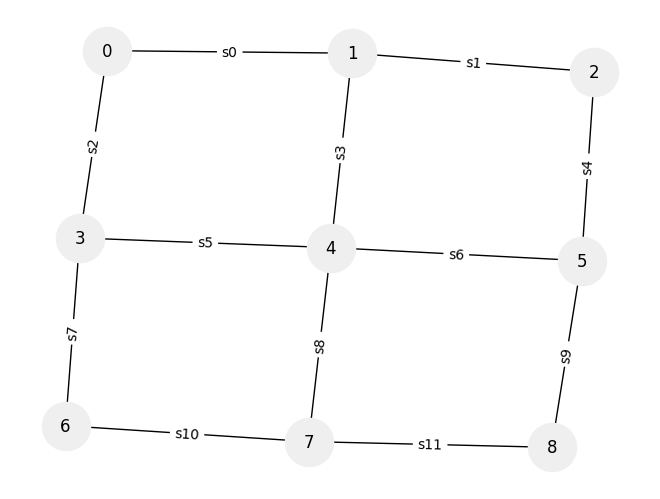

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_nodes_from([i for i in range(9)])
G.add_edges_from([(0,1),(1,2),(0,3),(1,4),(2,5),(3,4),(4,5),(3,6),(4,7),(5,8),(6,7),(7,8)])
options = {'node_size': 1200,'with_labels':'True'}
pos = nx.spring_layout(G, seed=7)
nx.draw(G, pos, **options, node_color='#efefef')

edge_labels={(0,1):'s0',(1,2):'s1',(0,3):'s2',(1,4):'s3',(2,5):'s4',(3,4):'s5',(4,5):'s6',(3,6):'s7',(4,7):'s8',(5,8):'s9',(6,7):'s10',(7,8):'s11'}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

### QUBO式
$i$番目の車が$j$番目の経路を通るときに$1$をとるバイナリ変数を$q_{i,j}$
とする. 

経路は道路をまとめた集合$S$とする. 
$$
S=[s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_{10},s_{11}]
$$

集合$S$を用いて経路を作成する. 

最小化したいQUBOコスト関数は,   

$$
\begin{align*}
QUBO&=\sum_{s \in S} (\sum_{s \in S_{i,j}} q_{i,j})^2 \\
&= (\sum_{s_0 \in S_{i,j}} q_{i,j})^2 + (\sum_{s_1 \in S_{i,j}} q_{i,j})^2 + \cdots + (\sum_{s_{11} \in S_{i,j}} q_{i,j})^2
\end{align*}
$$

$\sum_{s \in S_{i,j}} q_{i,j}$は車$i$が経路$j$を通過するときに道路$s$を通る経路について和をとります. 


道路$s$を通るすべての車の台数を表しており, $s$について和をとるQUBO式により, 道路$s$を通過する車の台数を最小化しています. 


たとえば, 以下の経路があるときに,  

$経路1 : s_0,s_3,s_8,s_{11}$  
$経路2 : s_2,s_7,s_{10},s_{11}$  
$経路3 : s_0,s_1,s_4,s_9$  

$s_0$が含まれるのは経路1と3なので, $s_0$のみのコスト関数は, 
$$
(q_{1,1}+q_{2,1}+q_{1,3}+q_{2,3})^2
$$

これをすべての道路についての和を取ることで, 道路を被らないように経路選択できる. 

制約式は, 各車は一つの経路のみ通る事ができる条件. 
$$
const=\sum_i (\sum_j q_{i,j} -1)^2
$$

### 問題設定

地点0から地点8までを車が移動するときに, 経路がなるべく被らないように経路分散を計る. 
車は2台あり, それぞれ下の経路をとる可能性がある. 

経路1 : s0,s3,s8,s11  
経路2 : s2,s7,s10,s11  
経路3 : s0,s1,s4,s9  

In [2]:
import numpy as np
from tytan import symbols_list, Auto_array, Compile, sampler

N=2
W=3
#q = Array.create('q', shape=(N,W), vartype='BINARY')
q = symbols_list((N, W))

#通過地点
s=np.array([[0,3,8,11],[2,7,10,11],[0,1,4,9]])

S=12#道路数


#式A
HA=0
for k in range(S):#道路
  tmp=0
  for j in range(W):#経路
    for i in range(N):#車
      for l in range(4):
        if s[j,l]==k:
          tmp += q[i,j]
  HA += tmp**2


#式C
HC=0
for i in range(N):#車
  tmp=0
  for j in range(W):#経路
    tmp+=q[i,j]
  HC += (tmp-1)**2


#式をつなげる
H = HA + 10*HC

Q, offset = Compile(H).get_qubo()

solver = sampler.SASampler()
result = solver.run(Q)
for r in result:
    arr, subs = Auto_array(r[0]).get_ndarray('q{}_{}')
    print(arr, int(r[1] + offset))

[[0 0 1]
 [0 1 0]] 8
[[0 1 0]
 [0 0 1]] 8
[[0 0 1]
 [1 0 0]] 10
[[0 1 0]
 [1 0 0]] 10
[[1 0 0]
 [0 0 1]] 10
[[1 0 0]
 [0 1 0]] 10
